In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is based on the [homework of week 8](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week08.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>

In [2]:
df = pd.read_csv('../data/reedfrogs.csv', sep=';')

# transforming pred and size into categorical variables
# pred_id: 0 (no); 1 (pred)
# size_id: 0 (small); 1 (big)
df['pred_id'] = (df['pred'] == 'pred').astype(int)
df['size_id'] = (df['size'] == 'big').astype(int)


df['pond'] = df.index
df

density  pred   size  surv  propsurv  pred_id  size_id  pond
0        10    no    big     9  0.900000        0        1     0
1        10    no    big    10  1.000000        0        1     1
2        10    no    big     7  0.700000        0        1     2
3        10    no    big    10  1.000000        0        1     3
4        10    no  small     9  0.900000        0        0     4
5        10    no  small     9  0.900000        0        0     5
6        10    no  small    10  1.000000        0        0     6
7        10    no  small     9  0.900000        0        0     7
8        10  pred    big     4  0.400000        1        1     8
9        10  pred    big     9  0.900000        1        1     9
10       10  pred    big     7  0.700000        1        1    10
11       10  pred    big     6  0.600000        1        1    11
12       10  pred  small     7  0.700000        1        0    12
13       10  pred  small     5  0.500000        1        0    13
14       10  pred  small     9  0.900000        1        0    14
15       10  pred  small     9  0.900000        1        0    15
16       25    no    big    24  0.960000        0        1    16
17       25    no    big    23  0.920000        0        1    17
18       25    no    big    22  0.880000        0        1    18
19       25    no    big    25  1.000000        0        1    19
20       25    no  small    23  0.920000        0        0    20
21       25    no  small    23  0.920000        0        0    21
22       25    no  small    23  0.920000        0        0    22
23       25    no  small    21  0.840000        0        0    23
24       25  pred    big     6  0.240000        1        1    24
25       25  pred    big    13  0.520000        1        1    25
26       25  pred    big     4  0.160000        1        1    26
27       25  pred    big     9  0.360000        1        1    27
28       25  pred  small    13  0.520000        1        0    28
29       25  pred  small    20  0.800000        1        0    29
30       25  pred  small     8  0.320000        1        0    30
31       25  pred  small    10  0.400000        1        0    31
32       35    no    big    34  0.971429        0        1    32
33       35    no    big    33  0.942857        0        1    33
34       35    no    big    33  0.942857        0        1    34
35       35    no    big    31  0.885714        0        1    35
36       35    no  small    31  0.885714        0        0    36
37       35    no  small    35  1.000000        0        0    37
38       35    no  small    33  0.942857        0        0    38
39       35    no  small    32  0.914286        0        0    39
40       35  pred    big     4  0.114286        1        1    40
41       35  pred    big    12  0.342857        1        1    41
42       35  pred    big    13  0.371429        1        1    42
43       35  pred    big    14  0.400000        1        1    43
44       35  pred  small    22  0.628571        1        0    44
45       35  pred  small    12  0.342857        1        0    45
46       35  pred  small    31  0.885714        1        0    46
47       35  pred  small    17  0.485714        1        0    47

For some of the models bellow, the MCMC sampling returned warnings like: 
<br>
*'There were 273 divergences after tuning. Increase target_accept or reparameterize.'*
<br>
<br>
This is an example of **Divergent transitions**. The best way to handle it is to reparametrize which means to transform a centered model into a non-centered as follows:
<br>
$ \alpha \sim \mathcal{N}(\mu,\,\sigma)$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Centered**
<br>
<br>
is mathematically identical to:
<br>
$ \alpha = \mu + z\sigma$<br>
$ z \sim \mathcal{N}(0,1)$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Non-centered**
<br>
<br>
Centered means that there're parameters inside the distribution. The non-centered form, even though mathematically identical to the centered one, makes Markov Chain more efficient for its inner workings this is a different geometry.

The following models are being built:
* m1 : ponds
* m2 : ponds + predation
* m3 : ponds + pond_size
* m4 : ponds + predation + pond_size
* m5 : ponds + predation + pond_size + interaction(predation + pond_size)

## Model with ponds predictors

In [3]:
with pm.Model() as m1:
    # prior for average pond
    a_bar = pm.Normal('a_bar', 0, 1.5)
    
    # prior for std of ponds
    sigma_a = pm.Exponential('sigma_a', 1)
    
    # adaptive prior
    a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    
    # log-odds for each pond
    p = pm.math.invlogit(a_pond[df.pond])
    
    # likelihood
    survival = pm.Binomial('survival', n=df.density, p=p, observed=df.surv)
    
    # posterior
    m1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

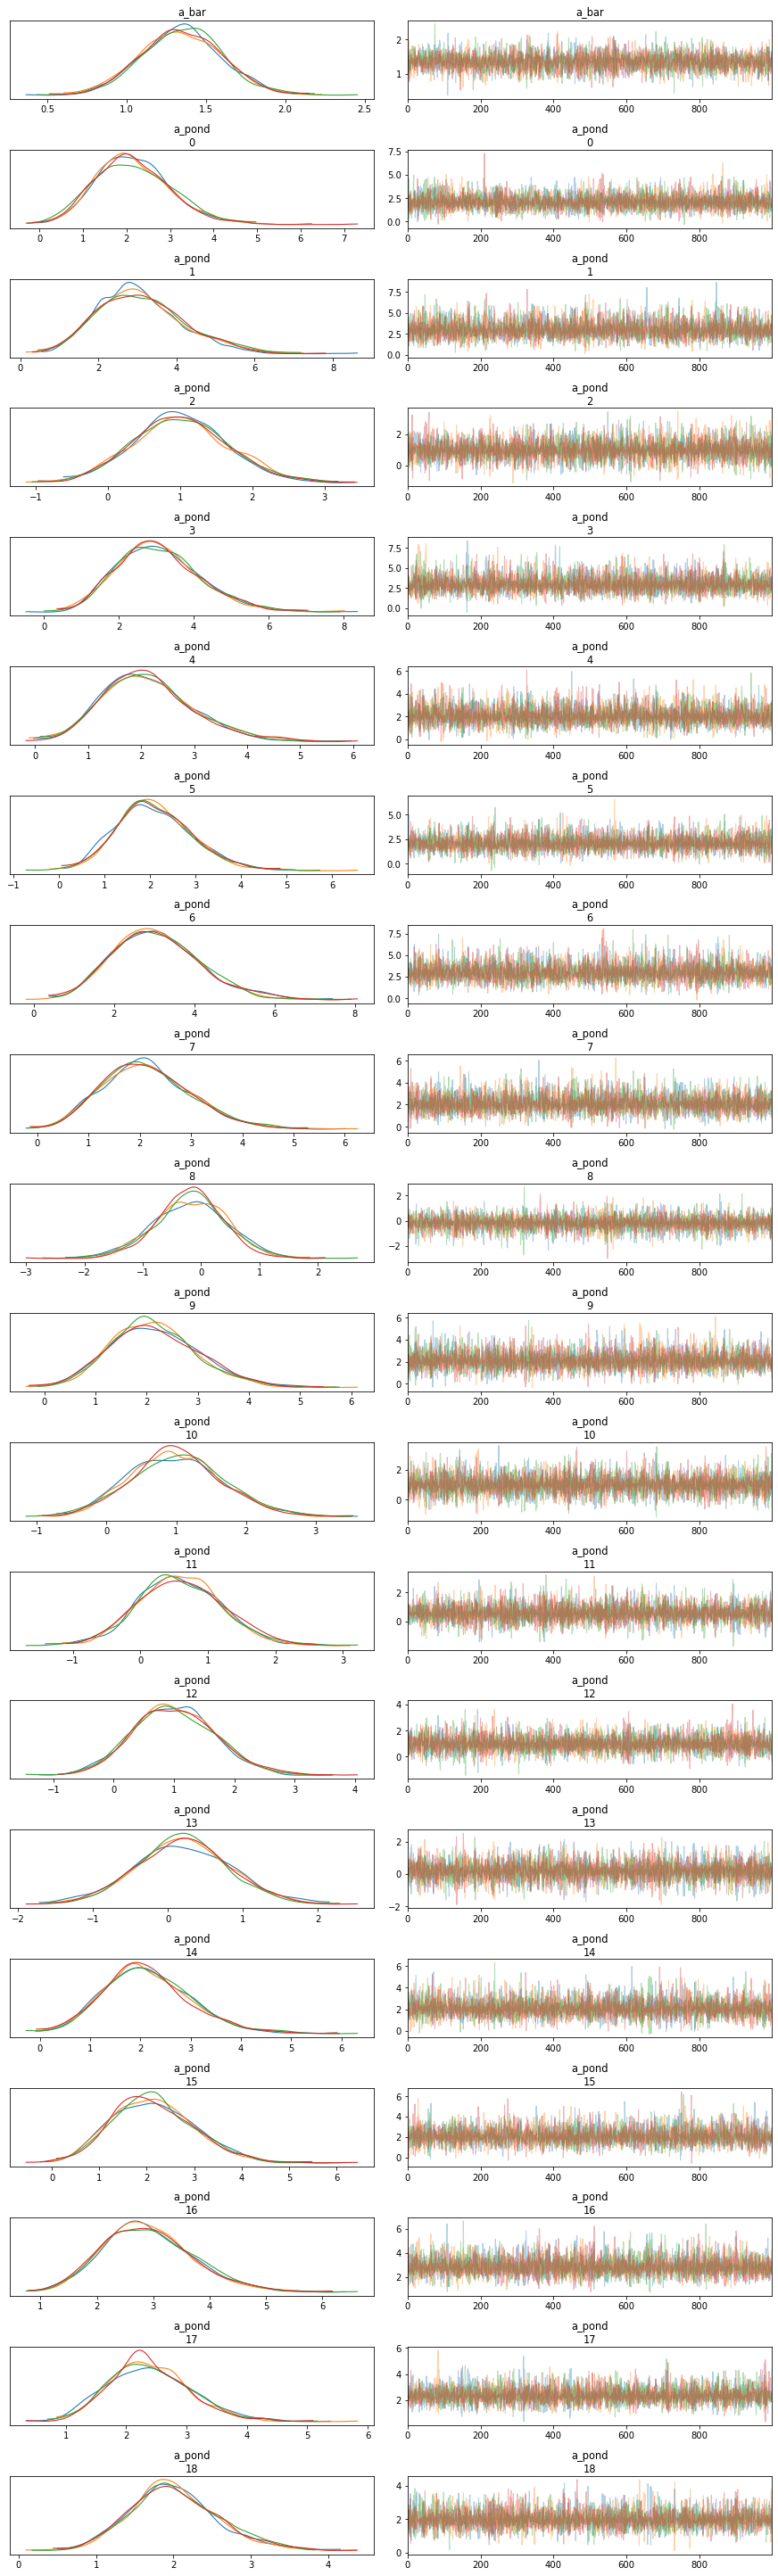

In [4]:
az.plot_trace(m1_trace)

In [5]:
az.summary(m1_trace, kind='stats', round_to=2)

mean    sd  hdi_3%  hdi_97%
a_bar       1.35  0.25    0.84     1.79
a_pond[0]   2.14  0.87    0.66     3.87
a_pond[1]   3.08  1.11    1.15     5.26
a_pond[2]   1.01  0.66   -0.24     2.25
a_pond[3]   3.08  1.14    1.09     5.24
a_pond[4]   2.13  0.85    0.64     3.82
a_pond[5]   2.10  0.83    0.57     3.64
a_pond[6]   3.07  1.09    1.22     5.21
a_pond[7]   2.14  0.87    0.60     3.77
a_pond[8]  -0.18  0.62   -1.34     0.99
a_pond[9]   2.16  0.88    0.56     3.83
a_pond[10]  1.01  0.67   -0.24     2.26
a_pond[11]  0.59  0.64   -0.62     1.77
a_pond[12]  1.01  0.68   -0.23     2.32
a_pond[13]  0.20  0.63   -0.98     1.43
a_pond[14]  2.14  0.88    0.55     3.81
a_pond[15]  2.14  0.88    0.53     3.74
a_pond[16]  2.91  0.81    1.36     4.37
a_pond[17]  2.39  0.67    1.16     3.62
a_pond[18]  2.01  0.58    0.98     3.15
a_pond[19]  3.67  1.03    1.81     5.58
a_pond[20]  2.40  0.67    1.21     3.69
a_pond[21]  2.38  0.66    1.20     3.65
a_pond[22]  2.39  0.65    1.21     3.56
a_pond[23]  1.70  0.52    0.78     2.70
a_pond[24] -1.00  0.44   -1.86    -0.22
a_pond[25]  0.16  0.39   -0.61     0.88
a_pond[26] -1.43  0.49   -2.41    -0.56
a_pond[27] -0.47  0.40   -1.18     0.32
a_pond[28]  0.16  0.39   -0.54     0.85
a_pond[29]  1.45  0.49    0.53     2.33
a_pond[30] -0.64  0.42   -1.41     0.15
a_pond[31] -0.30  0.39   -1.07     0.41
a_pond[32]  3.20  0.78    1.82     4.68
a_pond[33]  2.71  0.66    1.50     3.93
a_pond[34]  2.72  0.67    1.51     4.03
a_pond[35]  2.06  0.51    1.18     3.05
a_pond[36]  2.06  0.52    1.13     3.09
a_pond[37]  3.89  0.96    2.27     5.83
a_pond[38]  2.70  0.65    1.59     3.99
a_pond[39]  2.35  0.57    1.31     3.45
a_pond[40] -1.81  0.46   -2.68    -0.96
a_pond[41] -0.57  0.34   -1.20     0.09
a_pond[42] -0.45  0.33   -1.04     0.19
a_pond[43] -0.33  0.35   -0.98     0.33
a_pond[44]  0.58  0.34   -0.03     1.21
a_pond[45] -0.57  0.34   -1.23     0.06
a_pond[46]  2.06  0.51    1.14     3.06
a_pond[47]  0.00  0.33   -0.60     0.66
sigma_a     1.62  0.21    1.24     2.03

## Model with ponds + predation predictors

In [6]:
with pm.Model() as m2:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    
    b_pred = pm.Normal('b_pred', 0, 0.5)#, shape=len(df.pred_id.unique()))
    
    p = pm.math.invlogit(a_pond[df.pond] + b_pred*df.pred_id.values)
    
    survival = pm.Binomial('survival', n=df.density, p=p, observed=df.surv)
    
    m2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_pred, a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (51), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

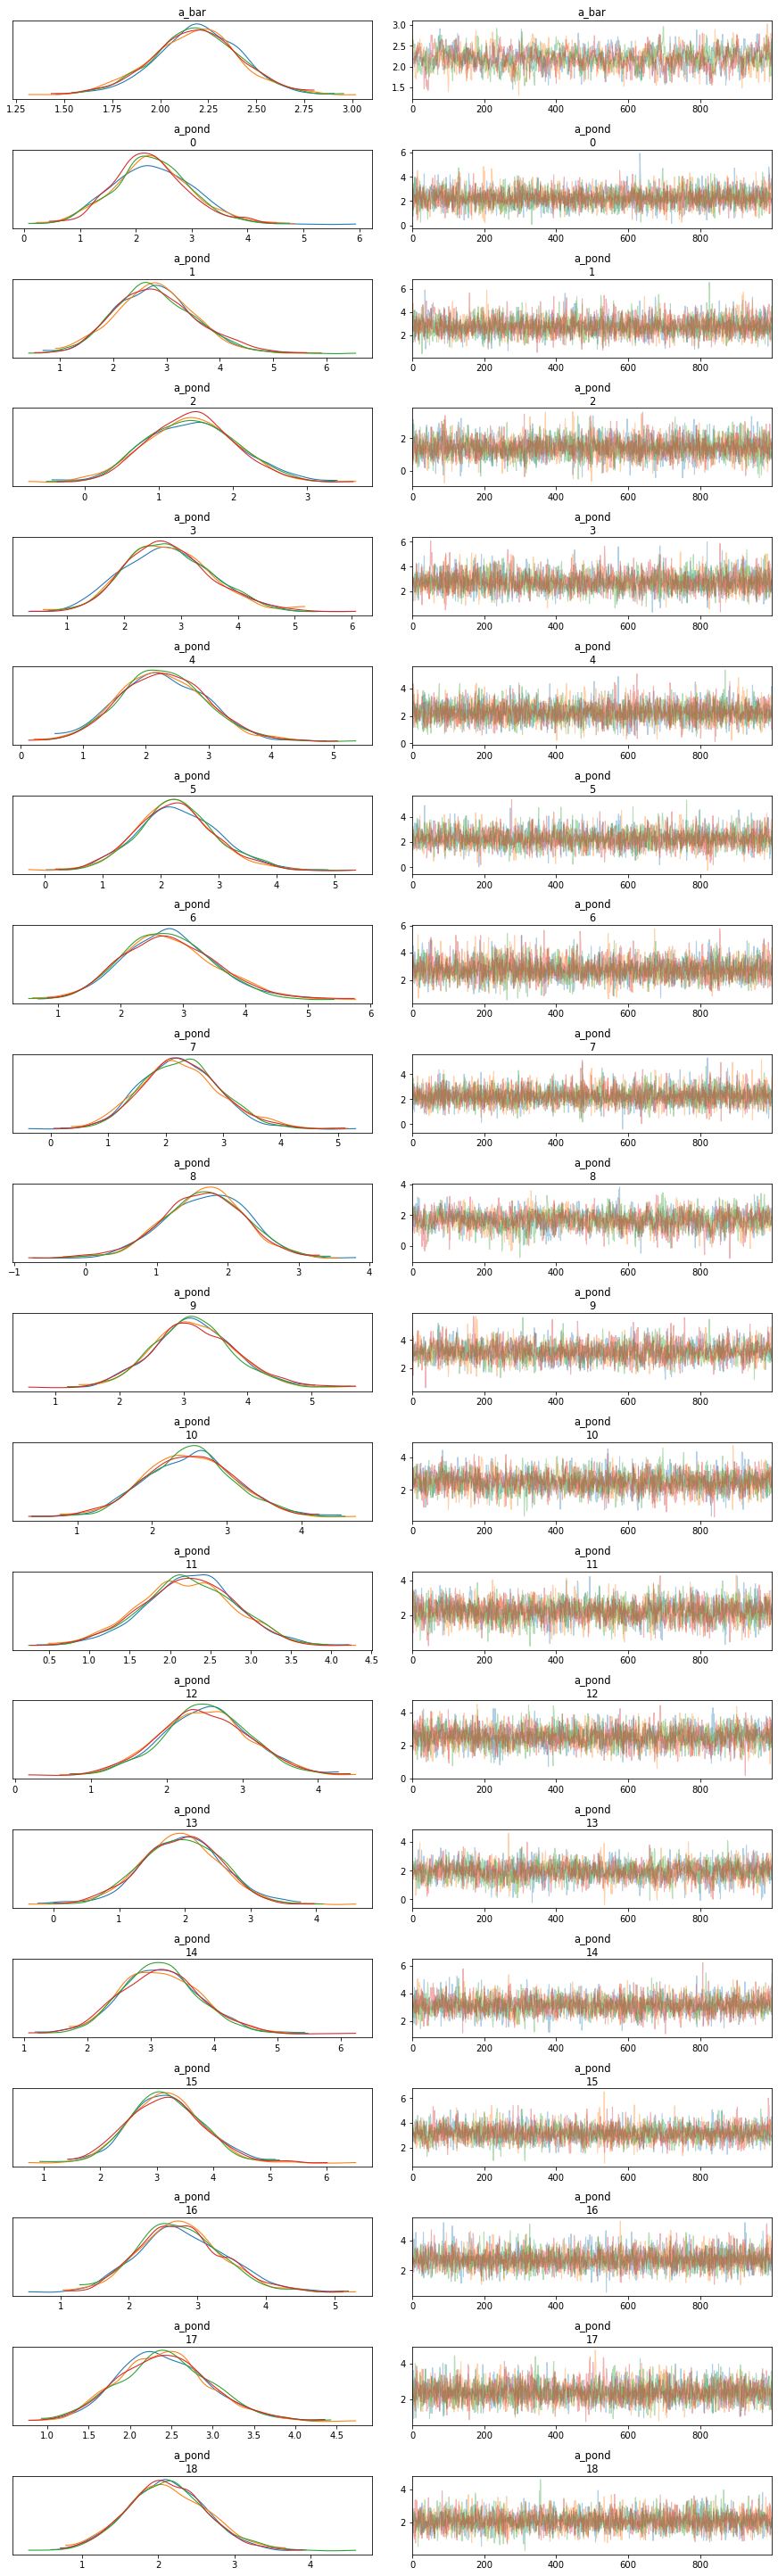

In [7]:
az.plot_trace(m2_trace)

In [8]:
az.summary(m2_trace, kind='stats', round_to=2)

mean    sd  hdi_3%  hdi_97%
a_bar       2.19  0.23    1.76     2.64
a_pond[0]   2.29  0.71    0.93     3.58
a_pond[1]   2.80  0.77    1.34     4.20
a_pond[2]   1.44  0.62    0.26     2.56
a_pond[3]   2.79  0.78    1.43     4.27
a_pond[4]   2.27  0.70    1.00     3.57
a_pond[5]   2.28  0.69    0.93     3.58
a_pond[6]   2.78  0.75    1.35     4.14
a_pond[7]   2.27  0.70    0.94     3.55
a_pond[8]   1.67  0.59    0.55     2.74
a_pond[9]   3.17  0.64    1.99     4.43
a_pond[10]  2.51  0.60    1.43     3.64
a_pond[11]  2.23  0.59    1.09     3.29
a_pond[12]  2.51  0.59    1.33     3.56
a_pond[13]  1.94  0.61    0.77     3.05
a_pond[14]  3.16  0.63    2.05     4.39
a_pond[15]  3.16  0.65    1.99     4.41
a_pond[16]  2.76  0.62    1.61     3.90
a_pond[17]  2.42  0.56    1.41     3.49
a_pond[18]  2.12  0.52    1.15     3.11
a_pond[19]  3.19  0.71    1.93     4.58
a_pond[20]  2.43  0.57    1.43     3.52
a_pond[21]  2.43  0.57    1.37     3.49
a_pond[22]  2.43  0.59    1.32     3.53
a_pond[23]  1.86  0.50    0.98     2.84
a_pond[24]  0.96  0.50    0.03     1.91
a_pond[25]  1.95  0.47    1.06     2.83
a_pond[26]  0.62  0.54   -0.42     1.60
a_pond[27]  1.40  0.49    0.45     2.28
a_pond[28]  1.95  0.47    1.10     2.86
a_pond[29]  3.00  0.49    2.09     3.91
a_pond[30]  1.26  0.50    0.33     2.18
a_pond[31]  1.54  0.48    0.62     2.42
a_pond[32]  2.97  0.61    1.92     4.12
a_pond[33]  2.65  0.55    1.62     3.68
a_pond[34]  2.65  0.55    1.66     3.71
a_pond[35]  2.15  0.47    1.28     3.06
a_pond[36]  2.15  0.47    1.29     3.08
a_pond[37]  3.36  0.67    2.11     4.61
a_pond[38]  2.64  0.55    1.66     3.67
a_pond[39]  2.39  0.50    1.46     3.30
a_pond[40]  0.28  0.54   -0.75     1.26
a_pond[41]  1.30  0.45    0.45     2.15
a_pond[42]  1.40  0.46    0.59     2.28
a_pond[43]  1.50  0.44    0.70     2.33
a_pond[44]  2.33  0.44    1.51     3.14
a_pond[45]  1.30  0.46    0.46     2.14
a_pond[46]  3.52  0.49    2.63     4.50
a_pond[47]  1.83  0.43    0.99     2.61
b_pred     -1.82  0.31   -2.36    -1.21
sigma_a     0.91  0.17    0.62     1.23

## Model with ponds + size predictors

In [9]:
with pm.Model() as m3:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    #a_pond = pm.Normal('a_pond', 0, 1, shape=len(df.pond))
    
    c_size = pm.Normal('c_size', 0, 0.5, shape=len(df.size_id.unique()))
    
    #p = pm.math.invlogit(a_bar + a_pond[df.pond]*sigma_a + c_size[df.size_id])
    p = pm.math.invlogit(a_pond[df.pond] + c_size[df.size_id])
    
    survival = pm.Binomial('survival', n=df.density, p=p, observed=df.surv)
    
    m3_trace = pm.sample(tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_size, a_pond, sigma_a, a_bar]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 12 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (52), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

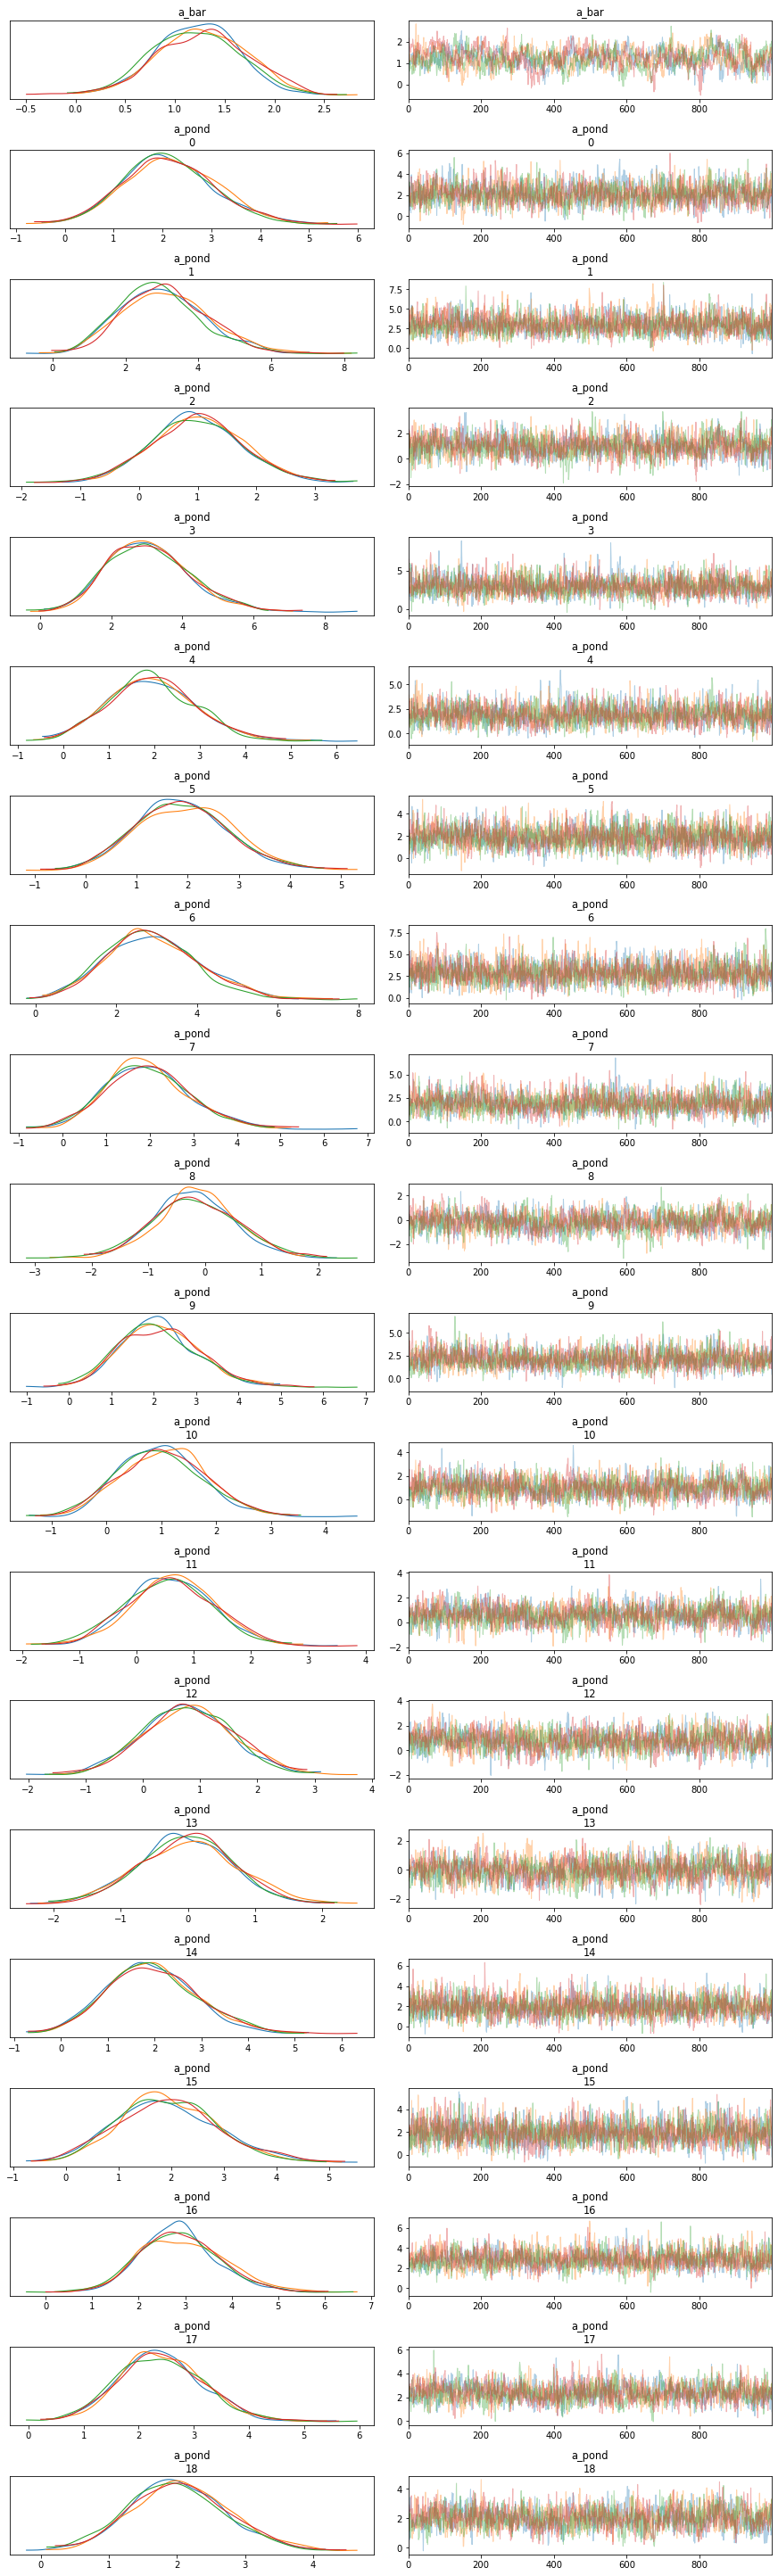

In [10]:
az.plot_trace(m3_trace)

## Model with ponds + predation + size predictors

In [11]:
with pm.Model() as m4:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', 0, 1, shape=len(df.pond))
    
    sigma_b = pm.Exponential('sigma_b', 1)
    b_pred = pm.Normal('b_pred', 0, sigma_b)#, shape=len(df.pred_id.unique()))
    
    c_size = pm.Normal('c_size', 0, 0.5, shape=len(df.pred_id.unique()))
    
    p = pm.math.invlogit(a_bar + a_pond[df.pond]*sigma_a + b_pred*df.pred_id + c_size[df.size_id])
    
    survival = pm.Binomial('survival', n=df.density, p=p, observed=df.surv)
    
    m4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_size, b_pred, sigma_b, a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (54), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

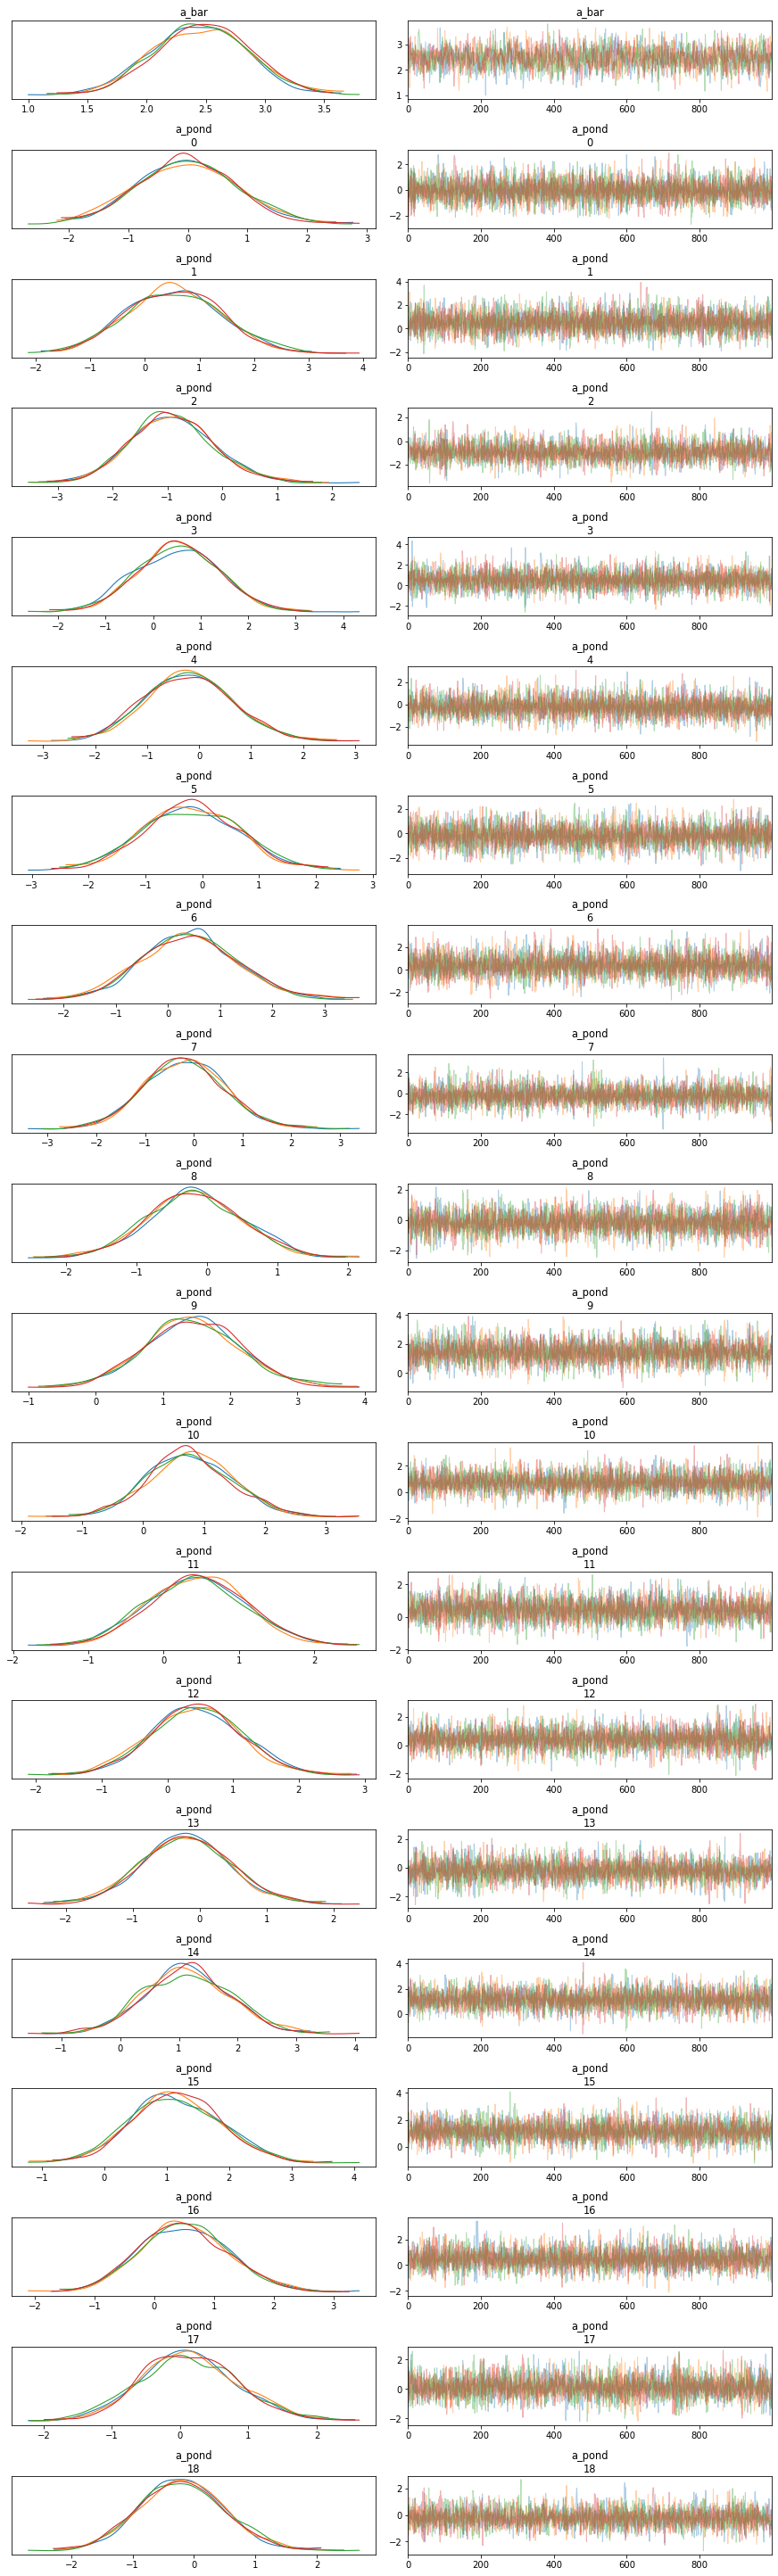

In [12]:
az.plot_trace(m4_trace)

## Model with ponds + interaction  (predation + size) predictors

In [13]:
with pm.Model() as m5:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', 0, 1, shape=len(df.pond))
    #a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    
    sigma_b = pm.Exponential('sigma_b', 1)
    #b_pred = pm.Normal('b_pred', 0, sigma_b, shape=len(df.pred_id.unique()))
    b_pred = pm.Normal('b_pred', 0, 1)
    
    c_size = pm.Normal('c_size', 0, 0.5, shape=len(df.pred_id.unique()))
    
    bc = pm.Normal('bc', 0, 0.5)
    
    #p = pm.math.invlogit(a_pond[df.pond] + c_size[df.size_id] + b_pred[df.pred_id]*c_size[df.size_id]) # + df.pred_id*c_size[df.size_id] + c_size[df.size_id])
    #p = pm.math.invlogit(a_bar+a_pond[df.pond]*sigma_a + c_size[df.size_id] + b_pred[df.pred_id]*sigma_b*c_size[df.size_id]) # + df.pred_id*c_size[df.size_id] + c_size[df.size_id])
    p = pm.math.invlogit(a_bar+a_pond[df.pond]*sigma_a + c_size[df.size_id] + b_pred*df.pred_id.values + bc*df.pred_id.values*df.size_id.values) # + df.pred_id*c_size[df.size_id] + c_size[df.size_id])
    
    survival = pm.Binomial('survival', n=df.density, p=p, observed=df.surv)
    
    m5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, c_size, b_pred, sigma_b, a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (55), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

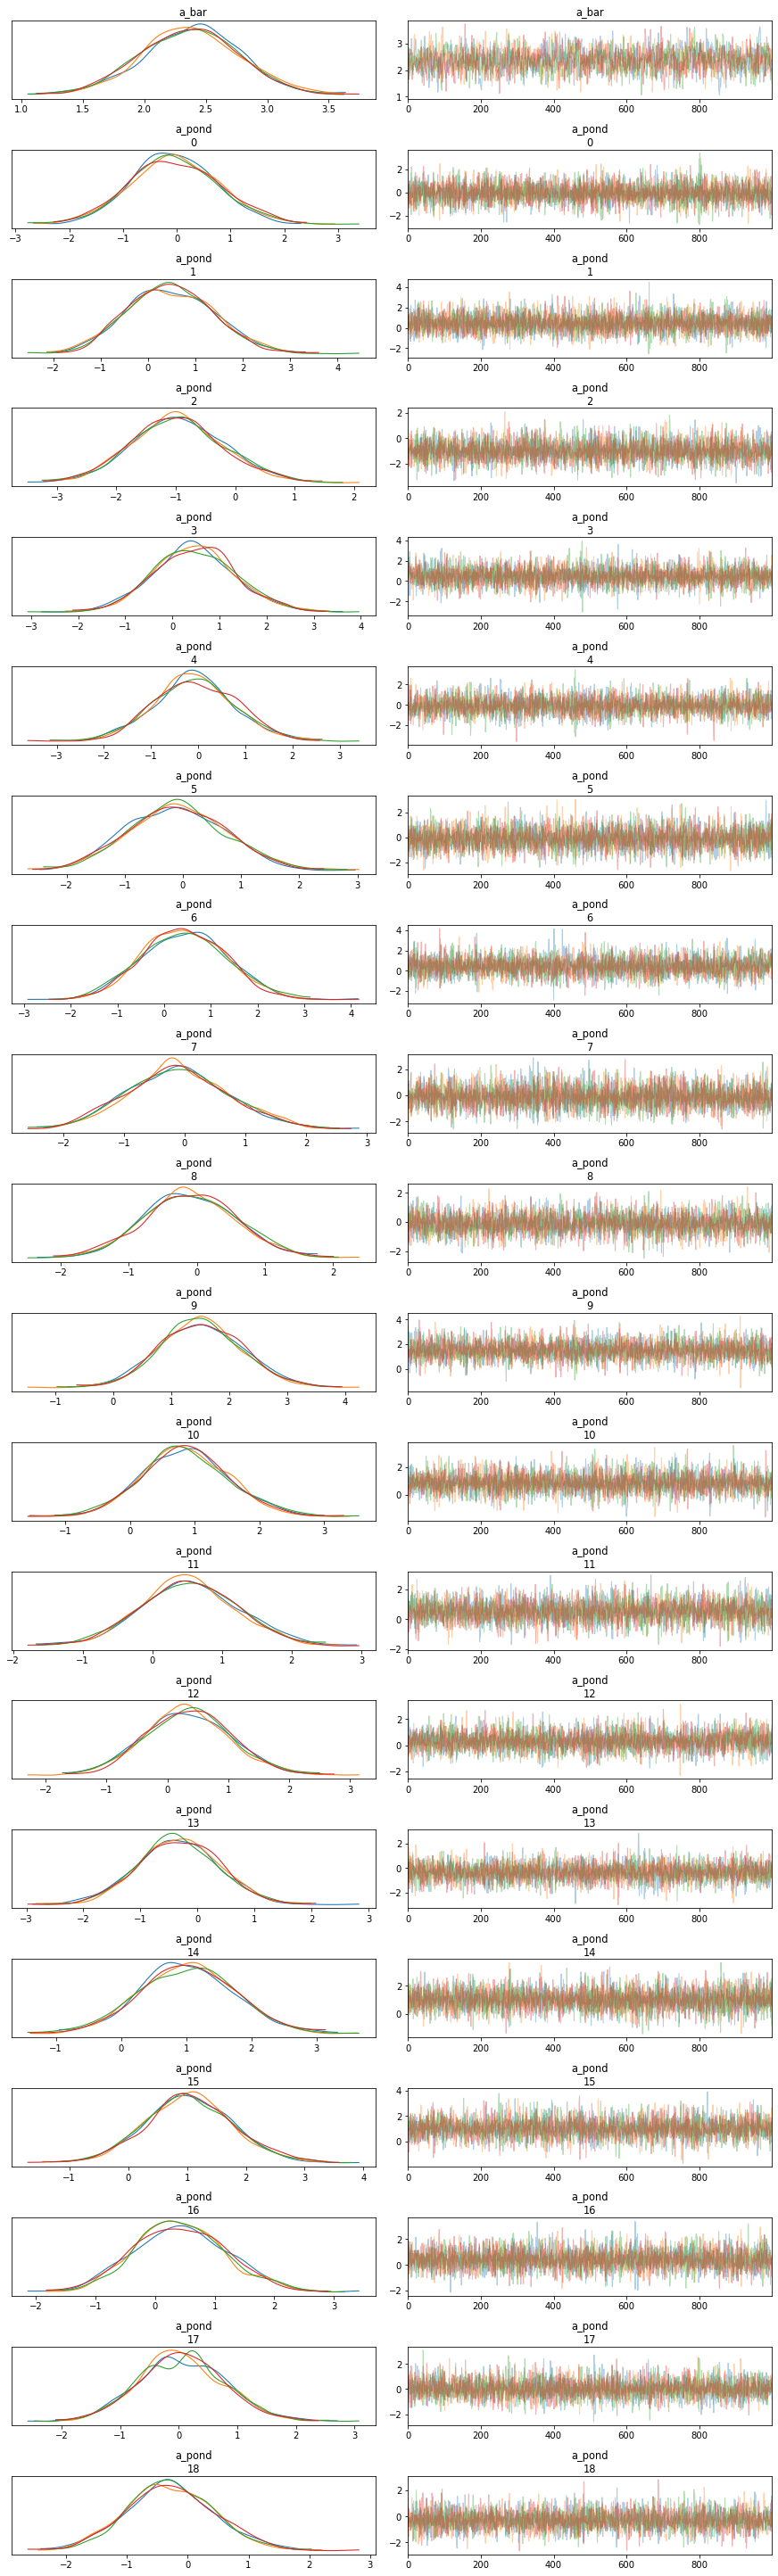

In [14]:
az.plot_trace(m5_trace)

In [15]:
az.compare({'m1': m1_trace, 'm2': m2_trace, 'm3': m3_trace, 'm4': m4_trace, 'm5': m5_trace}, ic='waic')

/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1425: UserWar

rank     waic   p_waic    d_waic    weight       se      dse warning  \
m2    0 -99.4416  19.3516         0  0.238071  3.64044        0    True   
m3    1 -99.7096   20.676  0.268037  0.220559  3.61301  2.03484    True   
m1    2 -99.9566  20.8941  0.515004  0.173452  4.09987  2.02947    True   
m4    3  -100.17  19.3325  0.728622   0.17404  4.51108  1.52145    True   
m5    4 -100.218  19.3631   0.77687  0.193878   4.6424  1.77316    True   

   waic_scale  
m2        log  
m3        log  
m1        log  
m4        log  
m5        log

Comparing the models with WAIC, they don't show much difference for fitting out-of-sample data as the **waic** values are pretty close (**d_waic** tells the small difference among them).

To compare the alphas among ponds for each model below we plot the variation between two of them.
As can be seen, the alpha for the ponds varies a lot for each model.

Text(0.5, 1.0, 'Tank 40: Estimated alpha for the 5 models')

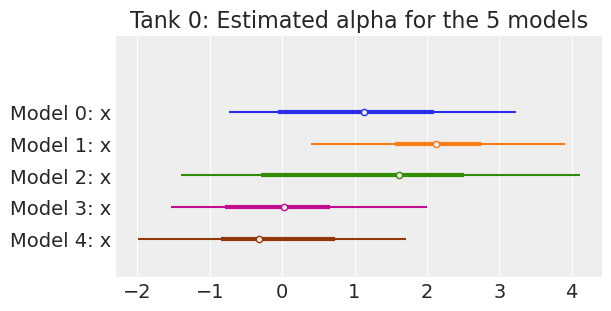

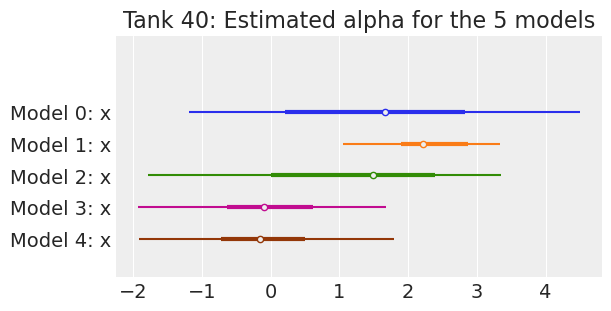

In [16]:
az.style.use("arviz-darkgrid")
axes = az.plot_forest([m1_trace['a_pond'][0], m2_trace['a_pond'][0], m3_trace['a_pond'][0],
                m4_trace['a_pond'][0], m5_trace['a_pond'][0]], 
                combined=True,
                figsize=[6,3])
axes[0].set_title('Tank 0: Estimated alpha for the 5 models')

axes = az.plot_forest([m1_trace['a_pond'][40], m2_trace['a_pond'][40], m3_trace['a_pond'][40],
                m4_trace['a_pond'][40], m5_trace['a_pond'][40]], 
                combined=True,
                figsize=[6,3])
axes[0].set_title('Tank 40: Estimated alpha for the 5 models')

In order to compare the effects of size of the pond (small/big) and the effect of predator on survival rates we plot their posterior below. 
<br>
Remember that:
* pred = 0 (no predators); pred = 1 (predators)
* size = 0 (small pond); size = 1 (big pond)

Text(0.5, 1.0, 'Effects of pond size (0:small, 1:big)')

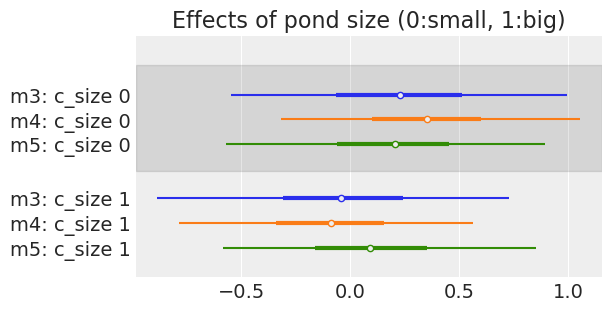

In [17]:
axes = az.plot_forest([m3_trace, m4_trace, m5_trace], 
                model_names=['m3', 'm4', 'm5'],
                var_names=['c_size'],
                combined=True,
                figsize=[6,3])
axes[0].set_title('Effects of pond size (0:small, 1:big)')

Effects of pond size show small or insignificant influence on the survival.

Text(0.5, 1.0, 'Effects of predation')

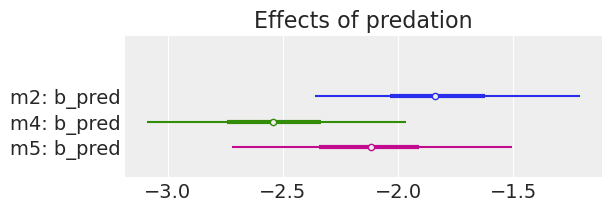

In [18]:
axes = az.plot_forest([m2_trace, m3_trace, m4_trace, m5_trace],
                model_names=['m2', 'm3', 'm4', 'm5'],
                var_names=['b_pred'],
                combined=True,
                figsize=[6,2])
axes[0].set_title('Effects of predation')

On the other hand, effects due to predation show a clear negative impact, as expected, on the survival. 

---
---

In [19]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Mon Apr 05 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

daft      : 0.1.0
scipy     : 1.5.4
matplotlib: 3.3.2
seaborn   : 0.11.0
numpy     : 1.19.1
pymc3     : 3.9.3
pandas    : 1.0.5
arviz     : 0.10.0

Watermark: 2.1.0

